In [1]:
# This script is a simple example of the pre-calibration process.
# The goal of pre-calibration is to remove models that produce unrealistic outputs. Usually this is done by comparing with observation
#   or data from previous work. 

# General steps:
# 1. Define prior ranges/distributions of each parameter. These ranges should be wide enough to cover the entire reasonable space.
# 2. Generate samples within the ranges (can be generated by LHS) neglecting correlations.
# 3. Define plausible/realistic ranges for each criterion (can be based on observation or previous work). 
# 4. Keep the samples that satisfy all criteria (so that the correlation relationship between parameters are considered).

# Some key studies using pre-calibration:
# 1. Knutti, R., Stocker, T. F., Joos, F., & Plattner, G.-K. (2002). Constraints on radiative forcing and future climate change 
#    from observations and climate model ensembles. Nature, 416(6882), 719–723. https://doi.org/10.1038/416719a
# 2. Edwards, N. R., Cameron, D., & Rougier, J. (2011). Precalibrating an intermediate complexity climate model. 
#    Climate Dynamics, 37(7), 1469–1482. https://doi.org/10.1007/s00382-010-0921-0
# 3. Sriver, R. L., Urban, N. M., Olson, R., & Keller, K. (2012). Toward a physically plausible upper bound of sea-level rise projections. 
#    Climatic Change, 115(3), 893–902. https://doi.org/10.1007/s10584-012-0610-6
# 4. Ruckert, K. L., Shaffer, G., Pollard, D., Guan, Y., Wong, T. E., Forest, C. E., & Keller, K. (2017). 
#    Assessing the Impact of Retreat Mechanisms in a Simple Antarctic Ice Sheet Model Using Bayesian Calibration. PloS One, 
#    12(1), e0170052. https://doi.org/10.1371/journal.pone.0170052

In [2]:
rm(list = ls())
graphics.off()
library(lhs)
#this function returns the fraction of a vector that is between a lower bound and an upper bound
frac_between <- function (vect1,vect2,vect3){ #vect2 is lower, vect3 is higher
  totlen<-length(vect1)
  out<-0
  for (i in 1:totlen){
    if ((vect1[i]<vect2[i]) | (vect1[i]>vect3[i])){
      out<-out+1
    }
  }
  return((totlen-out)/totlen)
}

Warning message:
"package 'lhs' was built under R version 3.6.3"

In [3]:
#assume we have 50 observation points
x<-c(1:50)
#assume true observed data has quadratic form plus a white noise. The goal is to find all the quadratic models that produce similar outputs.
set.seed(123)
observed<-0.05*(x-25)^2+rnorm(50,mean=0,sd=5)

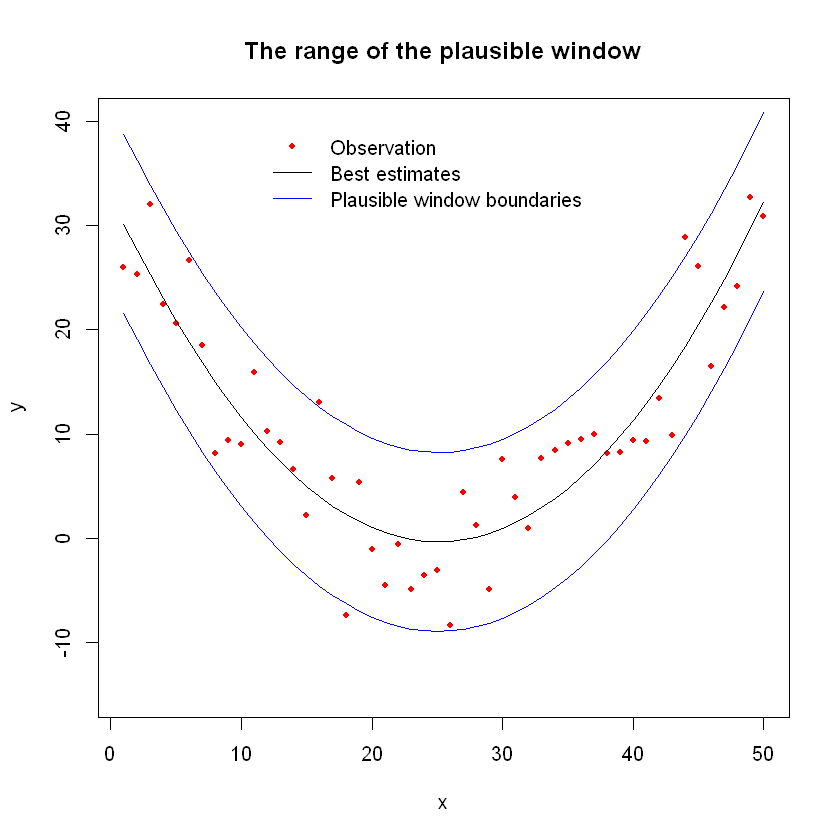

In [7]:
Data<-data.frame(observed=observed,x=x)
plot(x,observed,pch=20,xlab="x",ylab="y",ylim=c(-15,40),col="red")
#best estimate from a quadratic model regression
model<-lm(observed~poly(x,2),data = Data)
bestestimate<-predict(model,Data)
lines(x,bestestimate)
#find the boundaries around the best estimate that cover 95% observed data
difference<-abs(bestestimate-observed)
step<-quantile(difference,0.95)
upperbound<-bestestimate+step
lowerbound<-bestestimate-step
lines(x,upperbound,col="blue")
lines(x,lowerbound,col="blue")
legend(12,40,pch=c(20,NA,NA),lty=c(NA,1,1),col=c("red","black","blue"),bty="n",legend=c("Observation","Best estimates","Plausible window boundaries"))
title("The range of the plausible window")

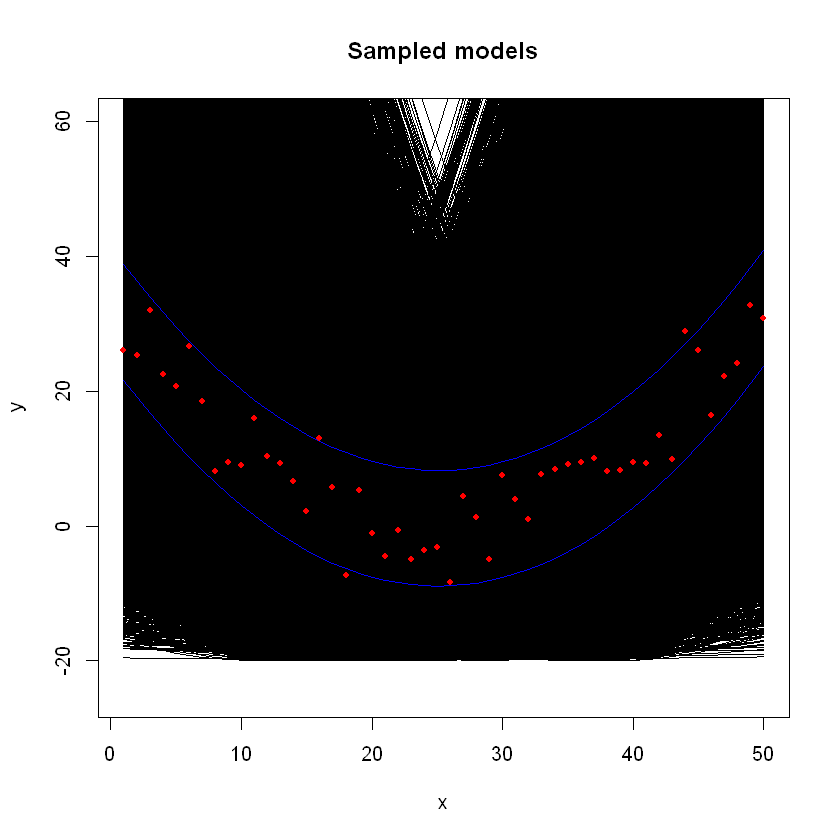

In [8]:
#wide prior range of three parameters
range_a<-c(0,0.2)
range_b<-c(10,40)
range_c<-c(-20,15)
plot(0,0,xlim=c(1,50),ylim=c(-25,60),xlab="x",ylab="y",type = "n")
#10000 Latin Hypercube sampling parameter samples
n<-10000
#these generated random LHS samples are in [0,1], we need to map them to parameter prior ranges.
LHS<-randomLHS(n,3)
a<-rep(NA,n)
b<-rep(NA,n)
c<-rep(NA,n)
yhind<-matrix(NA,nrow=n,ncol=50)
for (i in 1:n){
  #map LHS samples to parameter prior ranges
  a[i]<-range_a[1]+LHS[i,1]*(range_a[2]-range_a[1])
  b[i]<-range_b[1]+LHS[i,2]*(range_b[2]-range_b[1])
  c[i]<-range_c[1]+LHS[i,3]*(range_c[2]-range_c[1])
  #plot the hindcast calculated from each parameter sample
  yhind[i, ]<-a[i]*(x-b[i])^2+c[i]
  lines(x,yhind[i, ],lwd=0.1)
}
lines(x,upperbound,col="blue")
lines(x,lowerbound,col="blue")
points(x,observed,pch=20,col="red")
title("Sampled models")

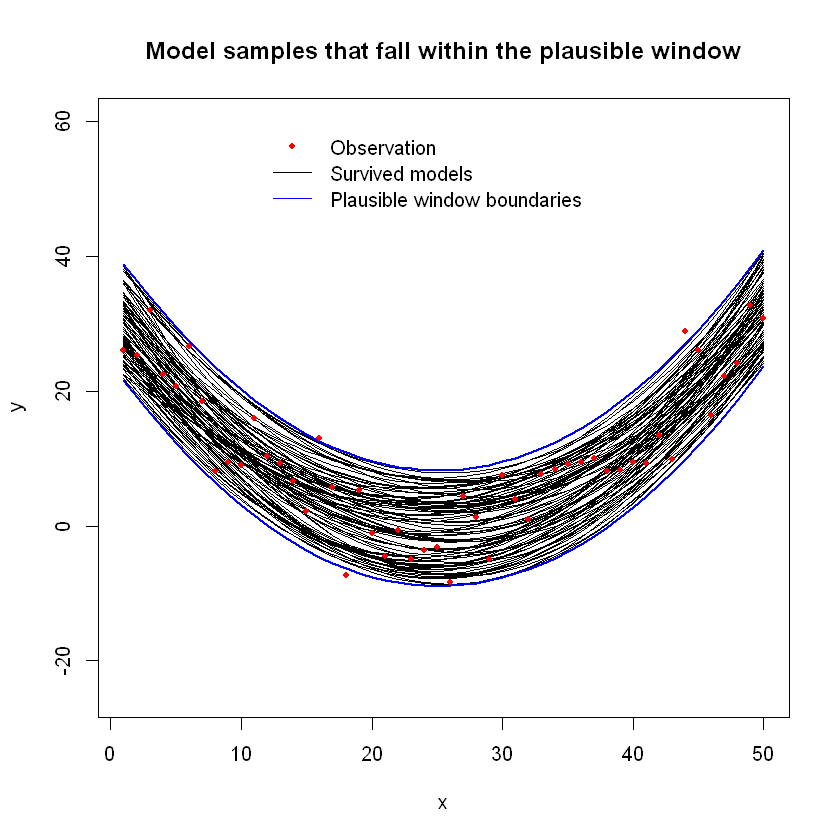

In [10]:
plot(0,0,xlim=c(1,50),ylim=c(-25,60),xlab="x",ylab="y",type = "n")
for (i in 1:n){
    #keep the samples whose hindcasts are within the boundaries
    if (frac_between(yhind[i, ],lowerbound,upperbound)==1){
        lines(x,yhind[i, ],lwd=0.1)
      }
  }
lines(x,upperbound,col="blue",lwd=2)
lines(x,lowerbound,col="blue",lwd=2)
points(x,observed,pch=20,col="red")
legend(12,60,pch=c(20,NA,NA),lty=c(NA,1,1),col=c("red","black","blue"),bty="n",legend=c("Observation","Survived models","Plausible window boundaries"))
title("Model samples that fall within the plausible window")

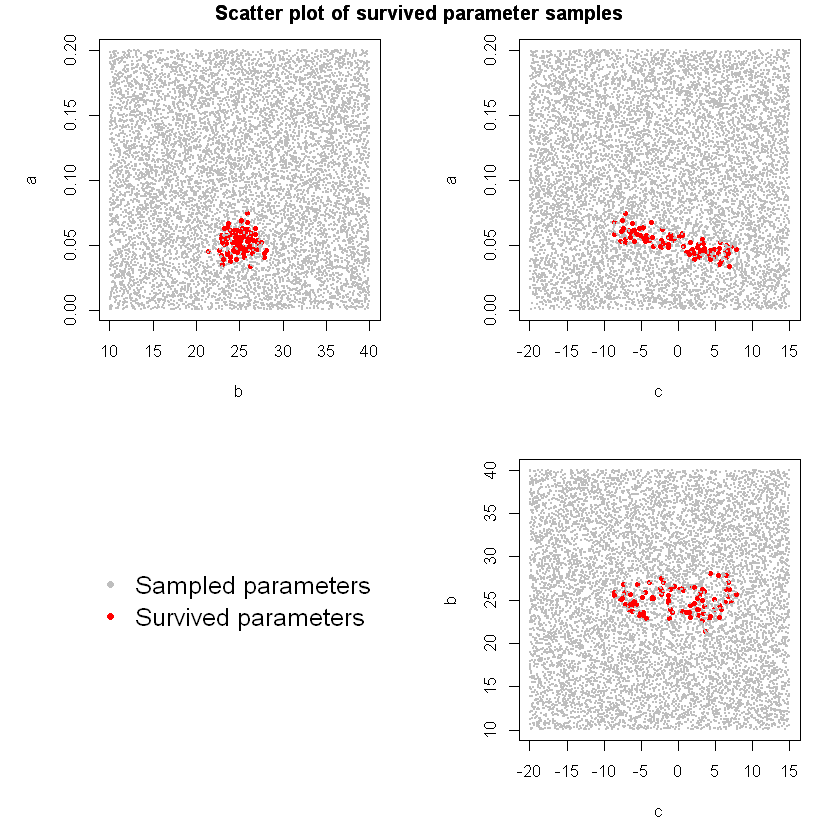

In [18]:
#scatter parameter plots, red points are the kept samples
#The scatter plots help us visulize the correlation between parameters.
par(mfrow=c(2,2),mar=c(5,5,2,2))
for (j in 1:2){
  for (k in 1:2){
    if ((j==1)&(k==1)){
      plot(0,0,xlim=range_b,ylim=range_a,xlab="b",ylab="a",type = "n")
      for (i in 1:n){
        if (frac_between(yhind[i, ],lowerbound,upperbound)==1){
          points(b[i],a[i],pch=20,cex=1,col="red")
        } else{
          points(b[i],a[i],pch=20,cex=0.1,col="grey")
        }
      }
    }
      title("Scatter plot of survived parameter samples", line = -1, outer = TRUE)
    if ((j==2)&(k==1)){
      plot(0,type='n',axes=FALSE,ann=FALSE)
        legend("center",pch=c(20,20),col=c("grey","red"),legend=c("Sampled parameters","Survived parameters"),bty="n",cex=1.5)
    }
    if ((j==1)&(k==2)){
      plot(0,0,xlim=range_c,ylim=range_a,xlab="c",ylab="a",type = "n")
      for (i in 1:n){
        if (frac_between(yhind[i, ],lowerbound,upperbound)==1){
          points(c[i],a[i],pch=20,cex=1,col="red")
        } else{
          points(c[i],a[i],pch=20,cex=0.1,col="grey")
        }
      }
    }
    if ((j==2)&(k==2)){
      plot(0,0,xlim=range_c,ylim=range_b,xlab="c",ylab="b",type = "n")
      for (i in 1:n){
        if (frac_between(yhind[i, ],lowerbound,upperbound)==1){
          points(c[i],b[i],pch=20,cex=1,col="red")
        } else{
          points(c[i],b[i],pch=20,cex=0.1,col="grey")
        }
      }
    }
  }
}